# Multi-Agent Tennis

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%matplotlib inline

import torch
import time
import config
import datetime

import numpy as np
import matplotlib.pyplot as plt

from data.maddpg import MADDPG
from collections import deque
from unityagents import UnityEnvironment

### 2. Initialize the unity Tennis environment

make sure the path to file_name is corrent and matching to your system. 
In here you should locate the Tennis environment file on your system.

In [2]:
env = UnityEnvironment(file_name="/home/maurice/Documents/udacity_new/data/Tennis_Linux_NoVis/Tennis.x86_64")
# env = UnityEnvironment(file_name="/home/maurice/Documents/udacity_new/data/Tennis_Linux/Tennis.x86_64")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 3. Get default environment parameters

In [3]:
brain_name  = env.brain_names[0]
brain       = env.brains[brain_name]
env_info    = env.reset(train_mode=True)[brain_name]
num_agents  = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size  = env_info.vector_observations.shape[1]

### 4. Set-up training algorithm 

In [4]:
def train(maddpg, n_eps=10000, max_steps=2000):
    
    scores = []
    scores_window = deque(maxlen=100)
    train_mode = True
    
#     frame_num = 0
    current_max = 1.0

    # training loop
    for i_eps in range(n_eps):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        state    = env_info.vector_observations
        maddpg.reset()
        agent_scores = np.zeros(num_agents)
        
        for step in range(max_steps):
            action     = maddpg.act(state, 1.0)
            env_info   = env.step(action)[brain_name] 
            reward     = env_info.rewards
            next_state = env_info.vector_observations
            done       = env_info.local_done
            maddpg.step(state, action, reward, next_state, done)
            
            state      = next_state
            agent_scores += reward
#             frame_num += 1
            
            if np.any(done): break
                
        max_score = np.max(agent_scores)
        scores_window.append(max_score)
        scores.append(max_score)                
    
        print('\rTraining Episode: {}\tAverage Score: {:.2f}'.format(i_eps, np.mean(scores_window)), end="")
        
        if i_eps % 100 == 0:
            print('\rTraining Episode: {}\tAverage Score: {:.2f}'.format(i_eps, np.mean(scores_window)))

        if max_score > current_max:
            current_max = max_score
            for i in range(len(maddpg.agents)):
                torch.save(maddpg.agents[i].actor.state_dict(),  'checkpoints/actor'  + str(i) +'checkpoint.pth')
                torch.save(maddpg.agents[i].critic.state_dict(), 'checkpoints/critic' + str(i) +'checkpoint.pth')

                
        if np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_eps, np.mean(scores_window)))
            break
            
            
    return scores
                
    
    
def plot_scores(scores, title=""):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()


### 5. Configure hyperparameters and perform training

In [5]:
# setup config datastruct with hyperparameters
config.seed        = 1
config.buffer_size = int(1e5)
config.batch_size  = 512
config.gamma       = 0.99
config.tau         = 2e-1
config.mu          = 0.0
config.theta       = 0.15
config.sigma       = 0.2
config.beta        = 0.4
config.beta_decay  = 10000

config.action_size         = action_size
config.state_size          = state_size
config.num_agents          = num_agents
config.actor_hidden_sizes  = [128, 64]
config.critic_hidden_sizes = [128, 64]
config.lr_actor            = 1e-4
config.lr_critic           = 3e-4
config.critic_weight_decay = 0.0
config.update_every        = 5

config.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Training Episode: 0	Average Score: 0.00
Training Episode: 100	Average Score: 0.00
Training Episode: 200	Average Score: 0.00
Training Episode: 300	Average Score: 0.00
Training Episode: 400	Average Score: 0.00
Training Episode: 500	Average Score: 0.01
Training Episode: 600	Average Score: 0.03
Training Episode: 700	Average Score: 0.03
Training Episode: 800	Average Score: 0.03
Training Episode: 900	Average Score: 0.06
Training Episode: 1000	Average Score: 0.10
Training Episode: 1100	Average Score: 0.11
Training Episode: 1200	Average Score: 0.10
Training Episode: 1300	Average Score: 0.11
Training Episode: 1400	Average Score: 0.09
Training Episode: 1500	Average Score: 0.11
Training Episode: 1600	Average Score: 0.11
Training Episode: 1700	Average Score: 0.10
Training Episode: 1800	Average Score: 0.12
Training Episode: 1900	Average Score: 0.12
Training Episode: 2000	Average Score: 0.13
Training Episode: 2100	Average Score: 0.14
Training Episode: 2200	Average Score: 0.16
Training Episode: 2300	

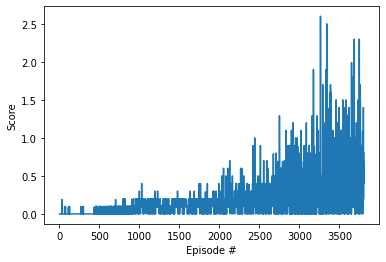

training took 0:28:55 [h:mm:ss]


In [6]:
# run training algorithm and plot results
maddpg = MADDPG(config)
tic    = time.perf_counter()
scores = train(maddpg, 5000, 2000)
toc    = time.perf_counter()

plot_scores(scores)
print('training took ' + str(datetime.timedelta(seconds=round(toc - tic))) + ' [h:mm:ss]')

### 6. Watch a smart agent!

In [7]:
# close the no_vis environment and open visual environment to see results
env.close()
env = UnityEnvironment(file_name="/home/maurice/Documents/udacity_new/data/Tennis_Linux/Tennis.x86_64")

ERROR:root:Exception calling application: Ran out of input
Traceback (most recent call last):
  File "/home/maurice/anaconda3/envs/drlnd/lib/python3.6/site-packages/grpc/_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "/home/maurice/anaconda3/envs/drlnd/lib/python3.6/site-packages/unityagents/rpc_communicator.py", line 26, in Exchange
    return self.child_conn.recv()
  File "/home/maurice/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
EOFError: Ran out of input


KeyboardInterrupt: 

In [ ]:
def run_smart_agent(trained_maddpg):

    for i in range(3): 
        env_info = env.reset(train_mode=False)[brain_name]
        state    = env_info.vector_observations
        trained_maddpg.reset()
        agent_scores = np.zeros(num_agents)
        
        while True:
            action     = trained_maddpg.act(state, 0.0)
            env_info   = env.step(action)[brain_name] 
            reward     = env_info.rewards
            next_state = env_info.vector_observations
            done       = env_info.local_done  
            state      = next_state
            agent_scores += reward
            
            if np.any(done): break
        print(f' Max score = {np.max(agent_scores)}')
        
                
# trained_maddpg = MADDPG(config)
# trained_maddpg.load_checkpoints()
# run_smart_agent(trained_maddpg)

In [ ]:
# env.close()